In [1]:
import numpy as np
import numpy.ma as ma

import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 1
%aimport sigproc
%aimport config_svm

In [3]:
%aimport svm

In [4]:
change_printopt = config_svm.printoptions

In [5]:
pic_dir = config_svm.pic_dir

In [6]:
import sys
Eps =  config_svm.Eps #sys.float_info.epsilon

# 3. Эксперименты на реальных данных

In [7]:
import re

r_strokenum = re.compile('\s+NUMSTROKES (\d)')
r_pntnum = re.compile('\s+POINTS (\d+) #*')
r_word = re.compile('WORD ([a-zA-Z0-9]) (trn|tst)_(UJI|UPV)_W(\d\d)-(01|02)', re.A)
strokenum = 0
num = 0
cnt = 0
max_d = 0

file_name = 'data/uji-penchars/ver2/ujipenchars2.txt'
data_file = open(file_name)
text_data = data_file.read().splitlines()
it_text = iter(text_data)

for line in it_text:
    if r_word.match(line):
        letter = r_word.match(line).group(1)
        num = 0
        line = next(it_text)
        strokenum = int(r_strokenum.match(line).group(1))
        cnt += 1
        while(strokenum):
            line = next(it_text)
            num += int(r_pntnum.match(line).group(1))
            strokenum -= 1 
        if max_d < num:
            max_d = num
            #print(letter, max_d) - Напечатать буквы макимизирующие вырпжение

In [8]:
keys = np.array(["0", "o", "O", "1", "2", "3", "4", "5", "6", "7", "8", "9",
        "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
        "n", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
        "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",
        "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"])
values = np.array(list(range(len(keys))))
y_values = np.array([0, 0, 0] + list(range(1, 10)) + list(range(10, 10 + 25)) + list(range(10, 10 + 25)))
lexicon = dict(zip(keys, values))
anti_lexicon = dict(zip(values, keys))
frame_size = np.array([13.6, 20.4]) 
UJI_ratio, UPV_ratio = 100, 152

print("Больше всего точек буквы = ", max_d)
masked_fill_value = 1.e-20
real_data = masked_fill_value*np.ones((len(keys), 60, 2, 2, max_d), dtype=np.float64)

Больше всего точек буквы =  392


In [9]:
print("Mbytes in data stored as masked arrays with length {0:d}: {1:.5f} Mb".format(max_d, real_data.nbytes / 2**(20)))

Mbytes in data stored as masked arrays with length 392: 44.50195 Mb


In [10]:
r_word = re.compile('WORD ([a-zA-Z0-9]) (trn|tst)_(UJI|UPV)_W(\d\d)-(01|02)', re.A)
r_pntnum = re.compile('\s+POINTS (\d+) #((\s+-?\d+)*)')

it_text = iter(text_data)
for line in it_text:
    if r_word.match(line):
        letter, UnivDivider, writer, repet = r_word.match(line).group(1, 3, 4, 5)
        line = next(it_text)
        strokenum = int(r_strokenum.match(line).group(1))
        stroke_offset = 0
        while(strokenum):
            line = next(it_text)
            pntnum_m = r_pntnum.match(line)
            pnts_num = int(pntnum_m.group(1))
            #print(pnts_num)
            #print(pntnum_m.group(2)[1:].split(sep=' '))
            pnts = np.array([int(pnt_xy) for pnt_xy in pntnum_m.group(2)[1:].split(sep=' ')])
            divider = 1
###can change divider parametr
            if UnivDivider == 'UPV':
                divider = UPV_ratio/UJI_ratio 
            #print(lexicon[letter], int(writer) - 1, int(repet) - 1)
            #try:
            real_data[lexicon[letter], int(writer) - 1, int(repet) - 1, 0,
                      stroke_offset:stroke_offset + pnts_num] = pnts[::2]/divider # x coords
            real_data[lexicon[letter], int(writer) - 1, int(repet) - 1, 1,
                      stroke_offset:stroke_offset + pnts_num] = pnts[1::2]/divider # y coords
            #except ValueError:
            #    print(pnts.shape)
            stroke_offset += pnts_num
            strokenum -= 1

In [11]:
real_data = ma.masked_values(real_data, value=masked_fill_value)

In [ ]:
with config_svm.printoptions(suppress=True):
    print(real_data)

In [13]:
def vis_letters(letter_index, real_data,frame=frame_size, ratio=UJI_ratio, vert_lines=np.array([7.5,12.7]), verbose=True):
    points_xy = real_data[letter_index].compressed().reshape(2, -1)
    fig = plt.figure(figsize=frame/2)
    ax = fig.gca()
    ax.plot(points_xy[0], points_xy[1], 'k-', linewidth=0.5)
    ax.scatter(points_xy[0, 1:-1], points_xy[1, 1:-1], c='b', marker='o', s=30)
    ax.scatter(points_xy[0, 0], points_xy[1, 0], c=(0, 0.95, 0), marker='o', s=40) #start
    ax.scatter(points_xy[0, -1], points_xy[1, -1], c=(0.95, 0, 0), marker='o', s=40) #end
    xlim = [0.0, frame[0]*ratio]
    ylim = [0.0, frame[1]*ratio]
    ax.xaxis.tick_top()
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xlim, vert_lines[[0, 0]]*ratio, 'k', lw=1)
    ax.plot(ylim, vert_lines[[1, 1]]*ratio, 'k', lw=1)
    ax.set_xticks(np.arange(*(xlim + [100])))
    ax.set_yticks(np.arange(*(ylim + [100])))
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=10)
    if verbose:
        ax.set_title("Буква '{0:s}'\tреспондент {1:d}\tпопытка {2:d}".format(
                anti_lexicon[letter_index[0]], letter_index[1] + 1, letter_index[2] + 1),fontsize=20, y=1.03)
    ax.invert_yaxis()
    ax.grid()     

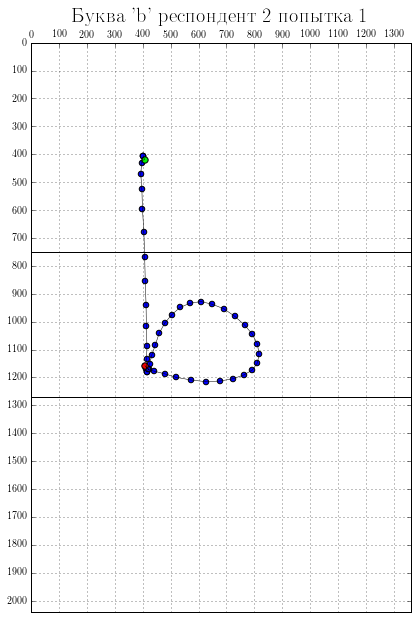

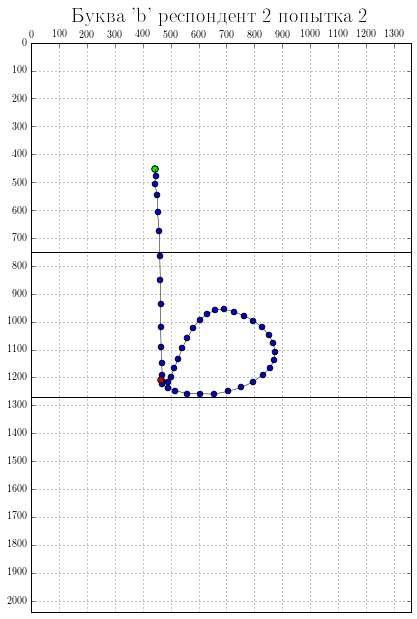

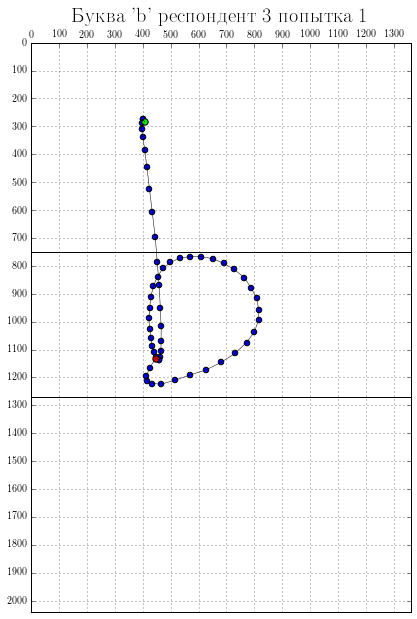

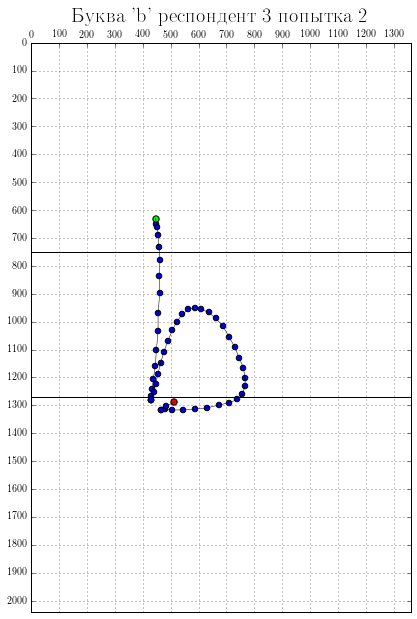

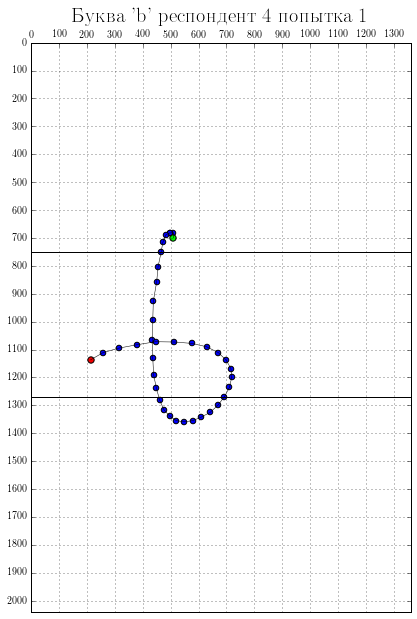

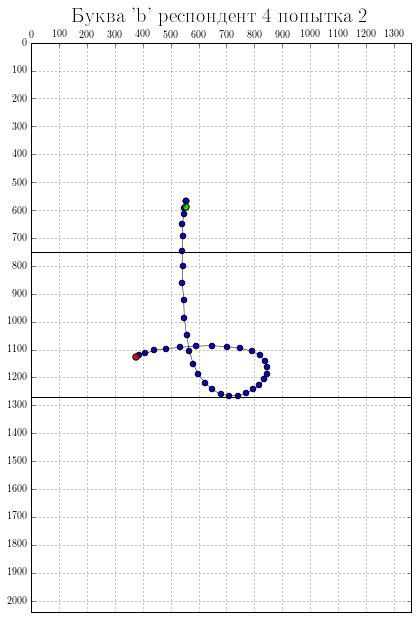

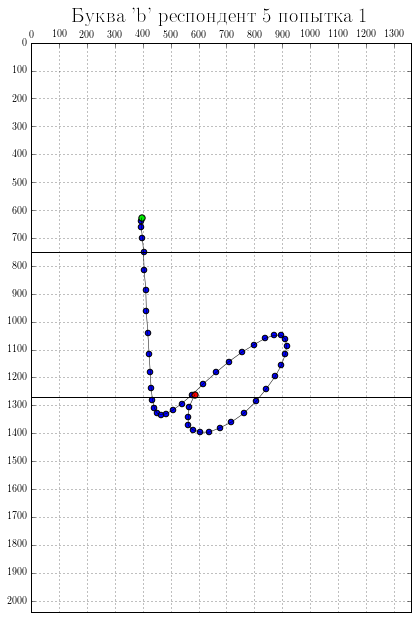

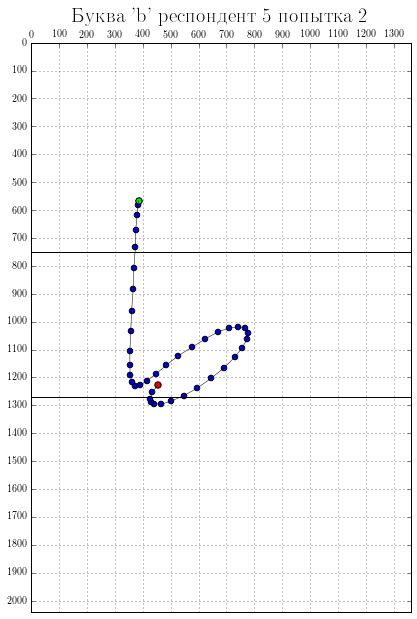

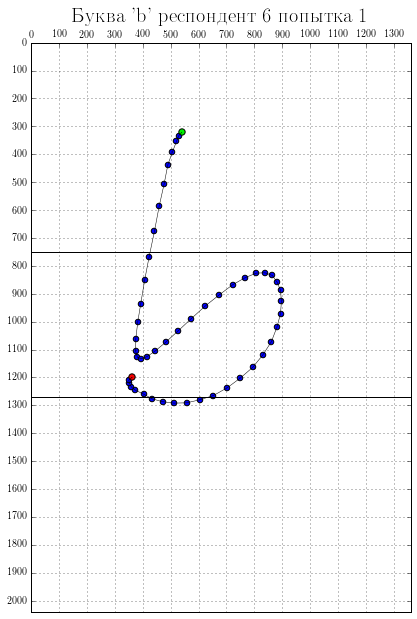

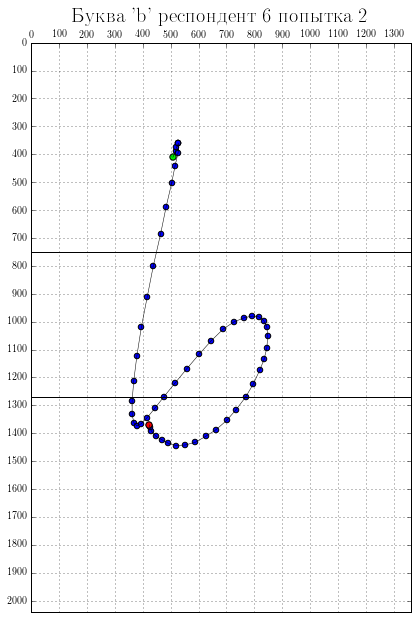

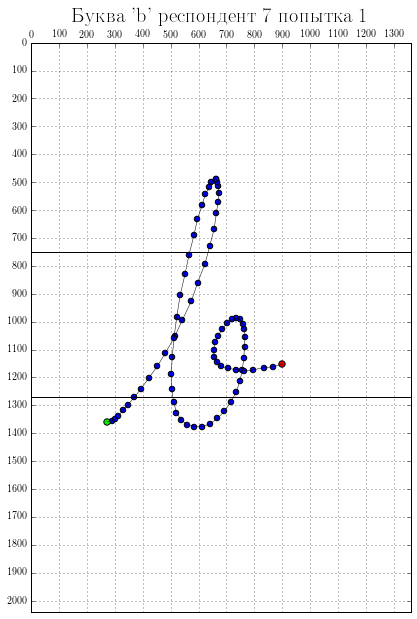

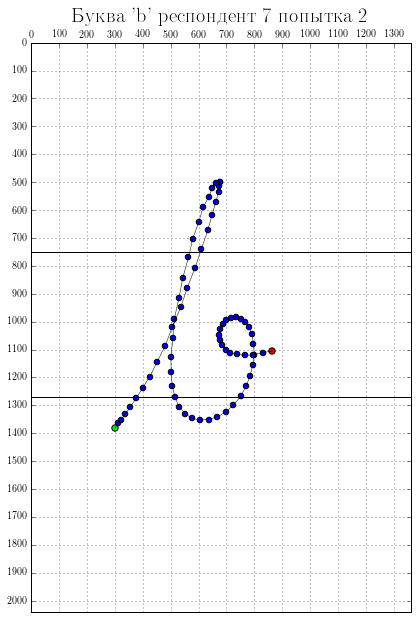

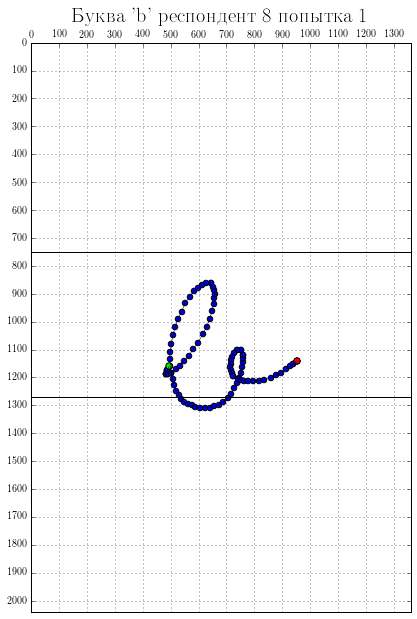

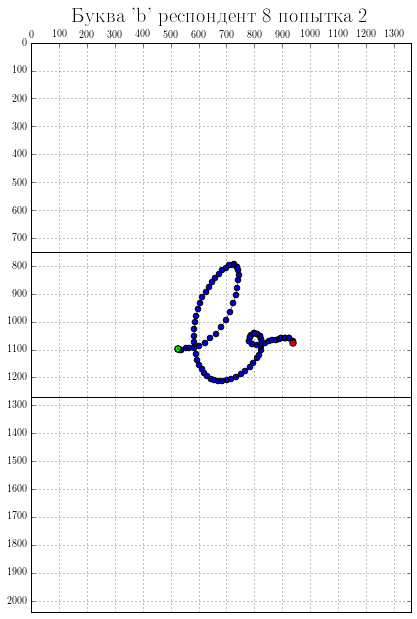

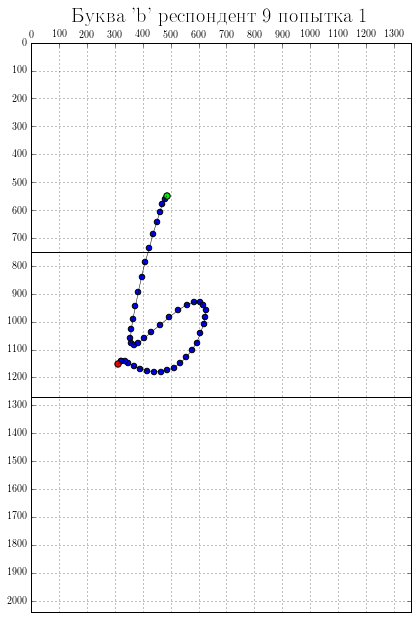

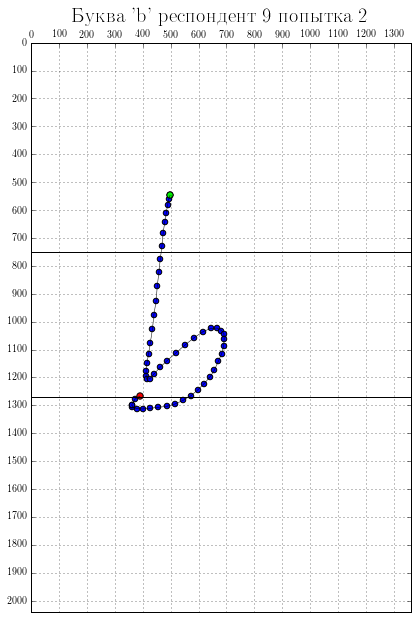

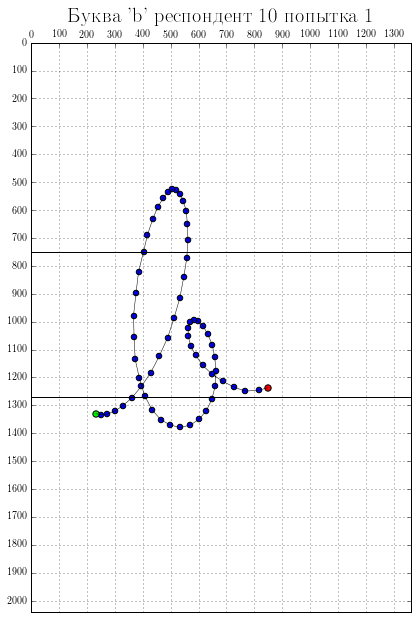

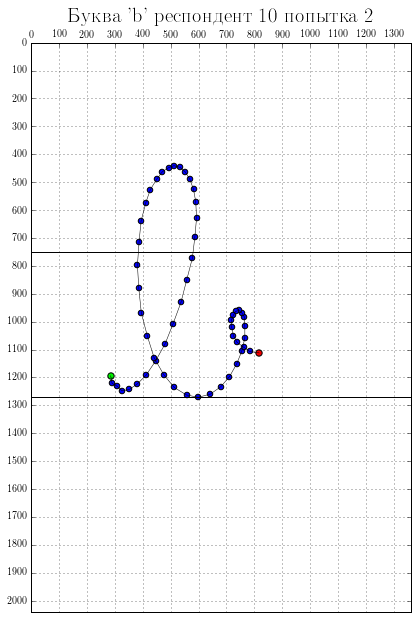

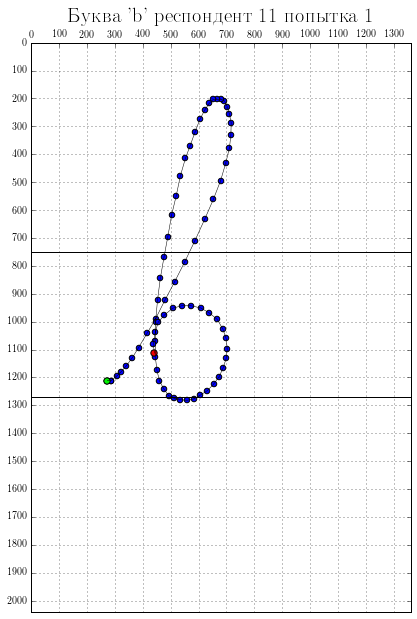

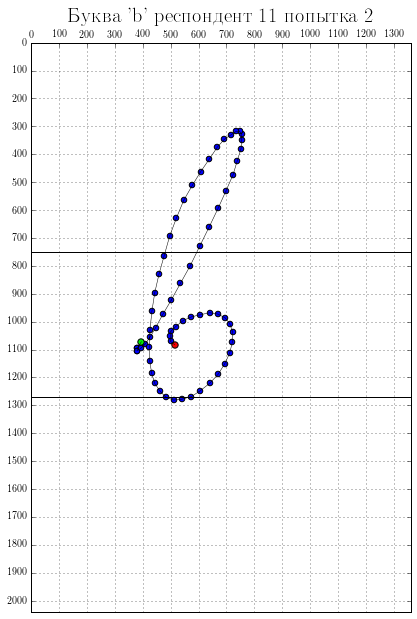

In [30]:
for writer in range(1, 11, 1):
    for repet in range(2):
        vis_letters((lexicon['b'], writer, repet), real_data)

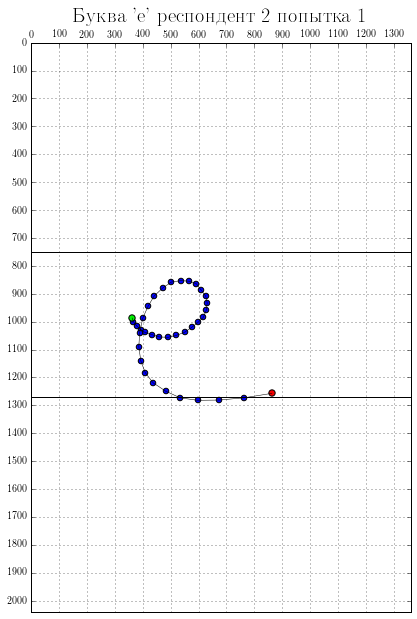

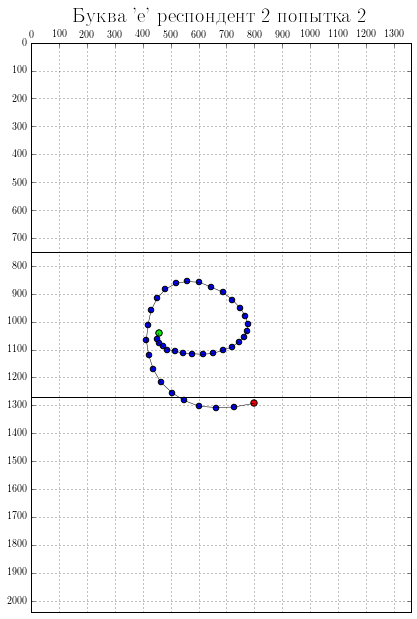

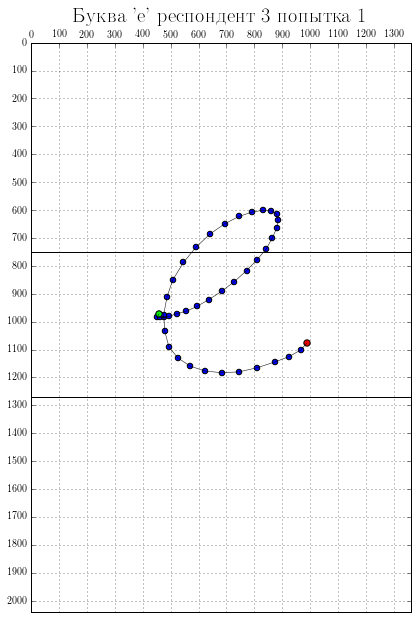

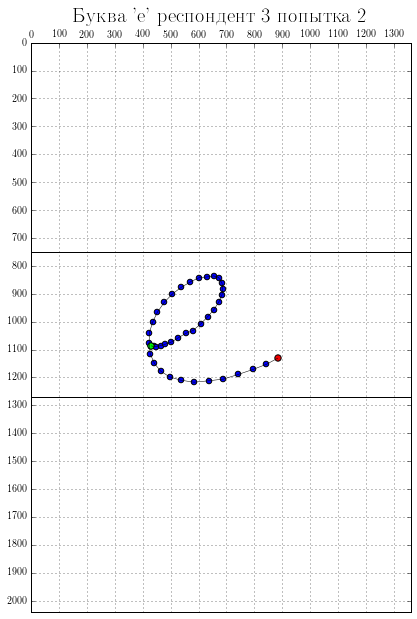

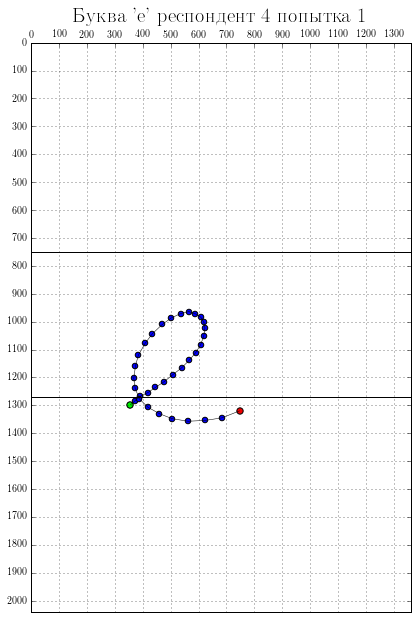

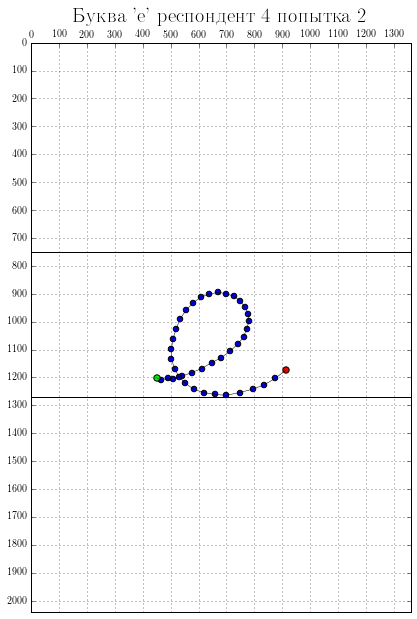

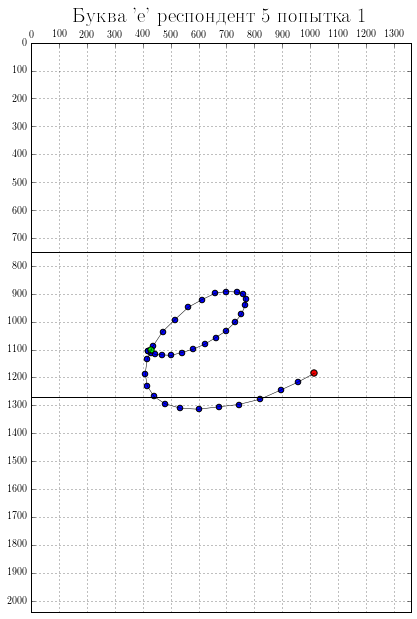

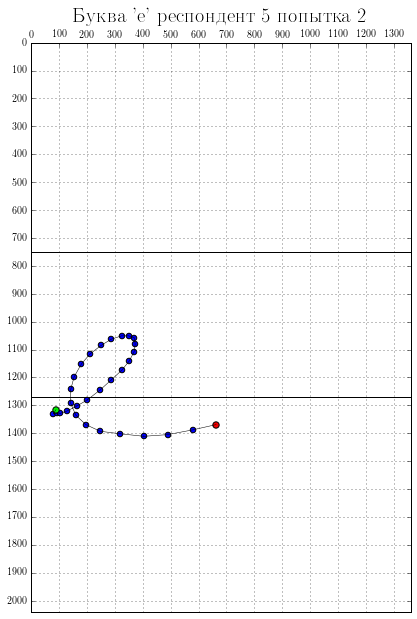

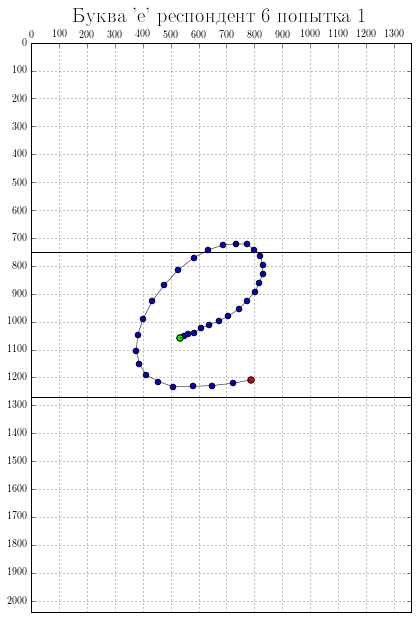

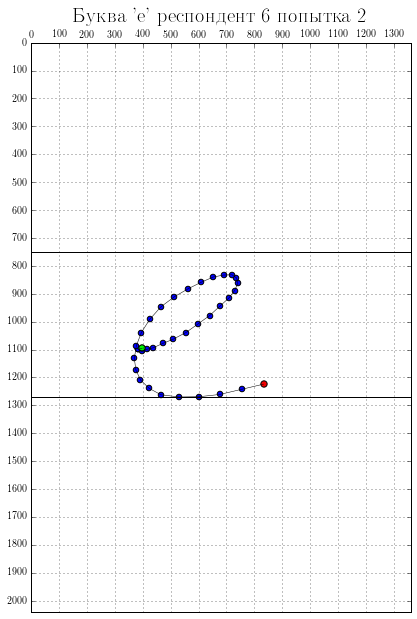

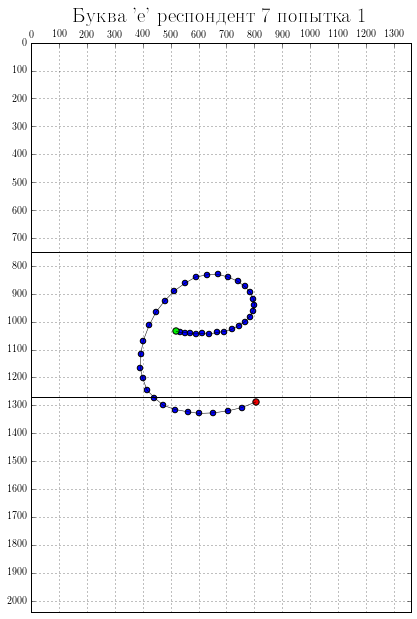

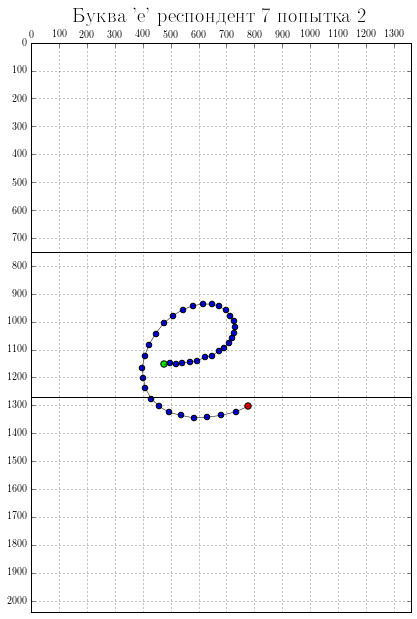

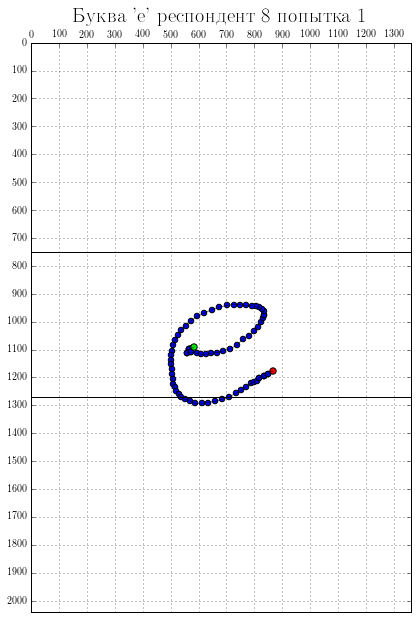

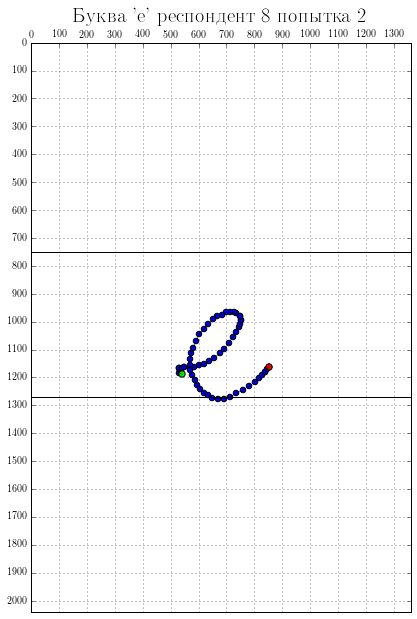

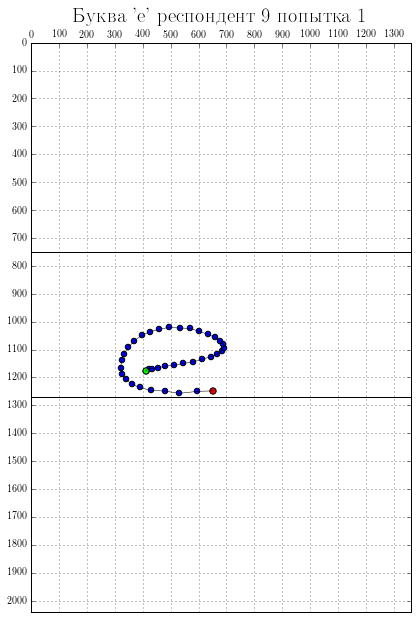

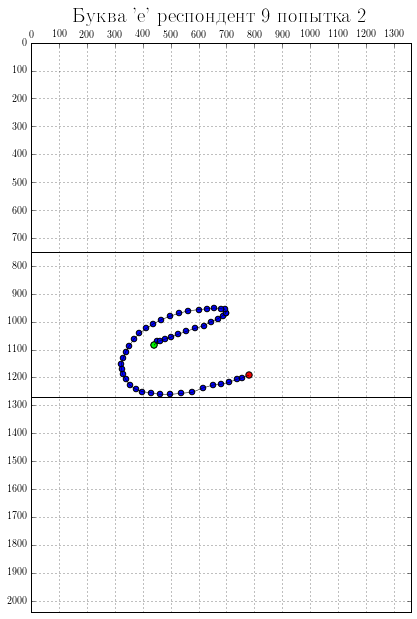

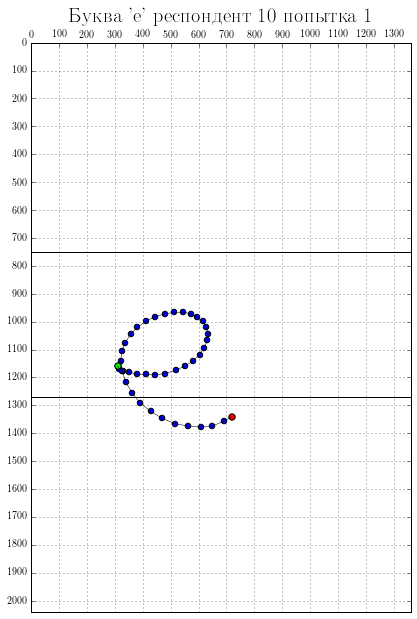

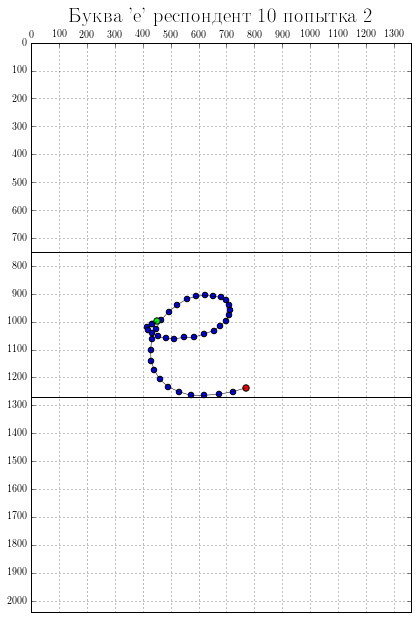

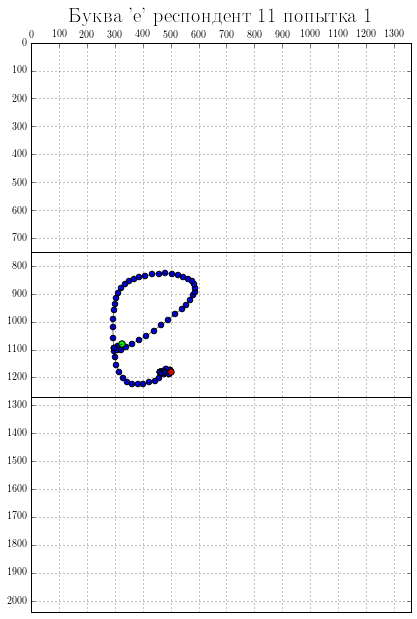

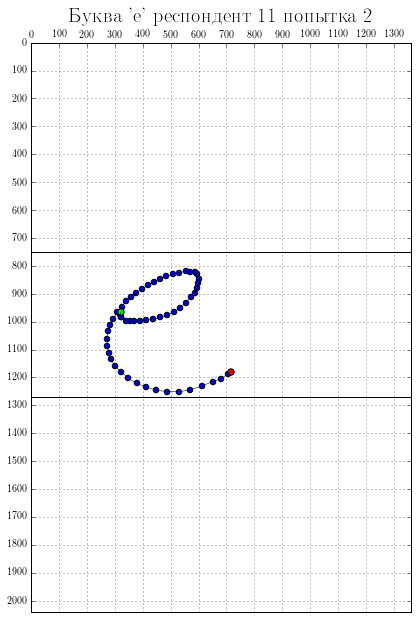

In [31]:
for writer in range(1, 11, 1):
    for repet in range(2):
        vis_letters((lexicon['e'], writer, repet), real_data)

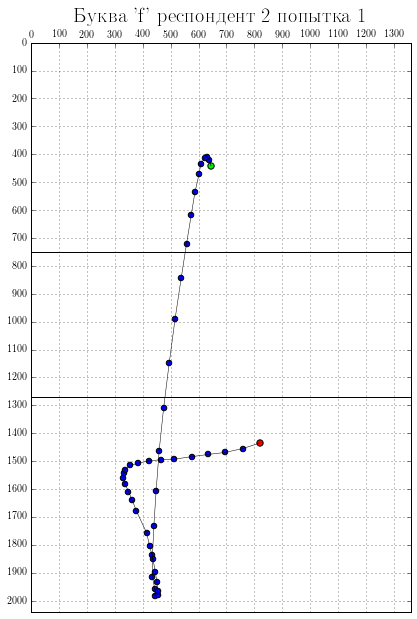

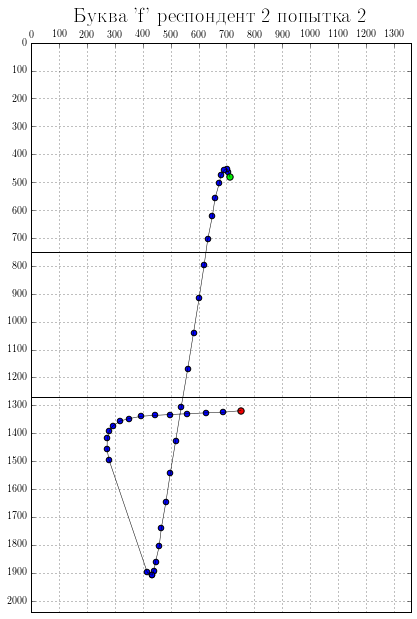

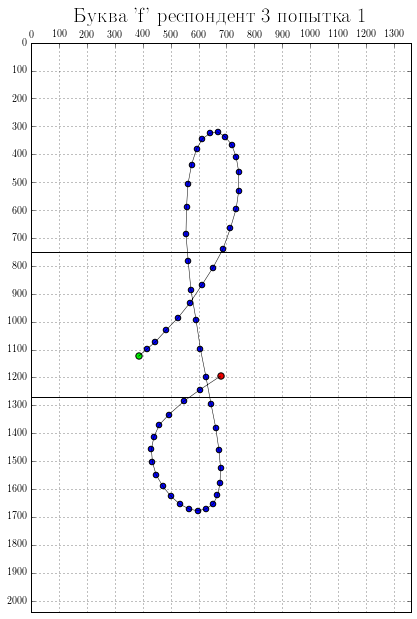

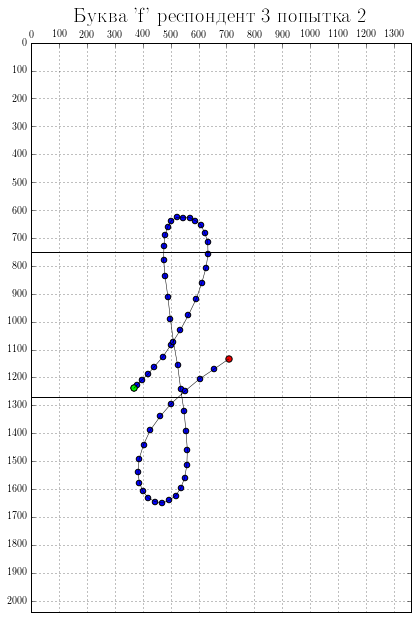

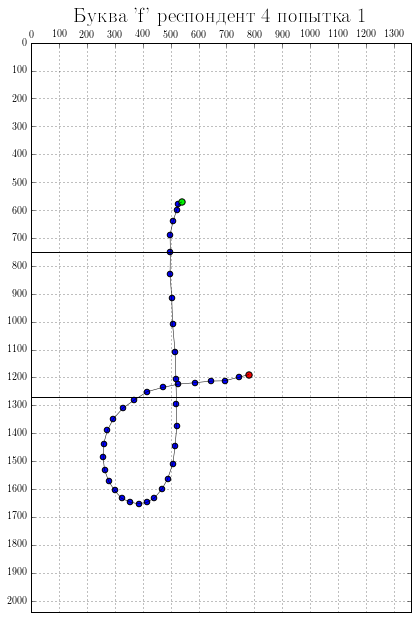

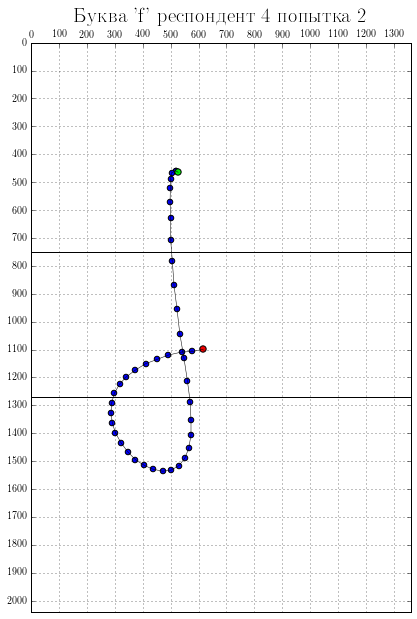

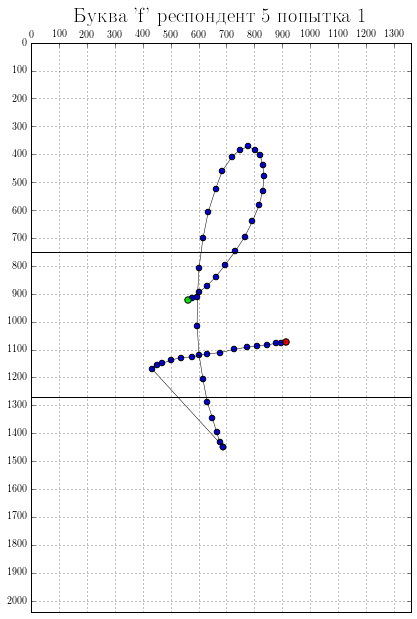

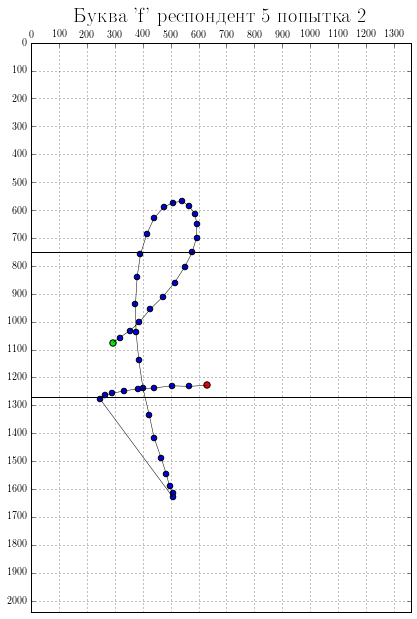

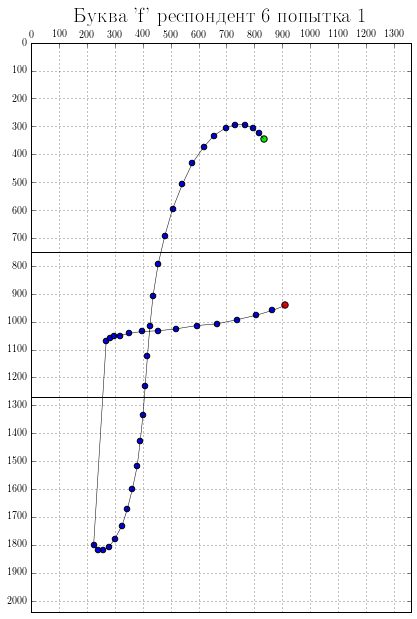

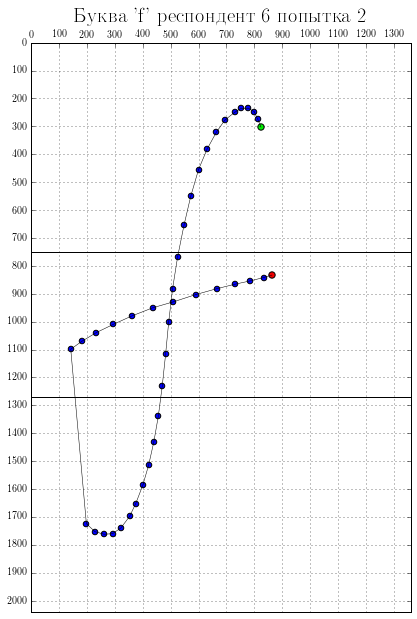

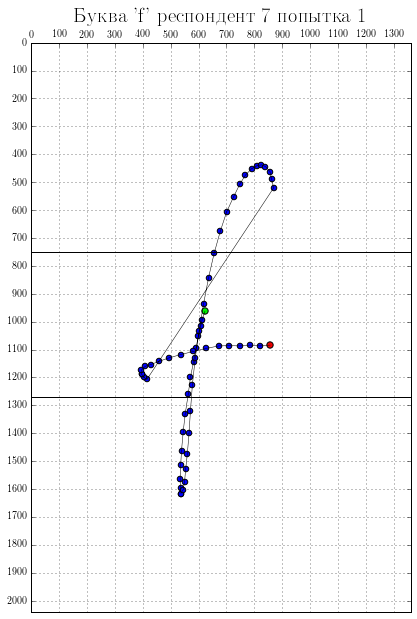

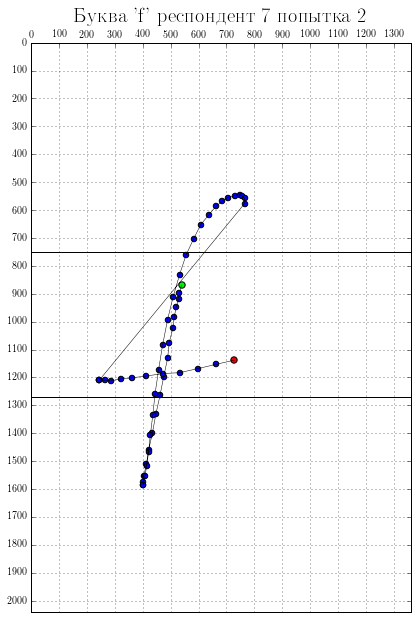

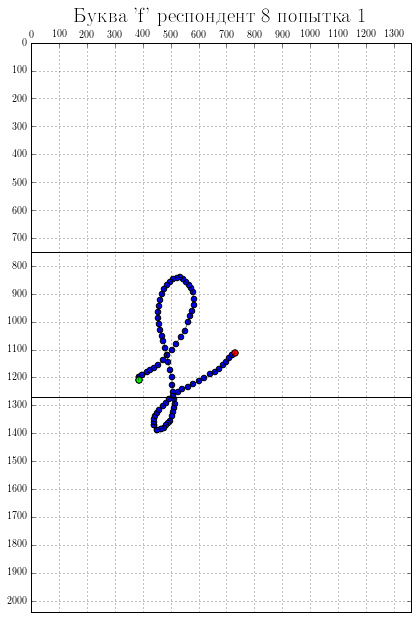

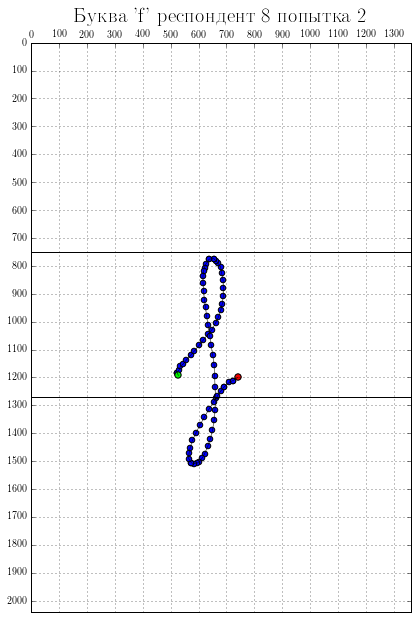

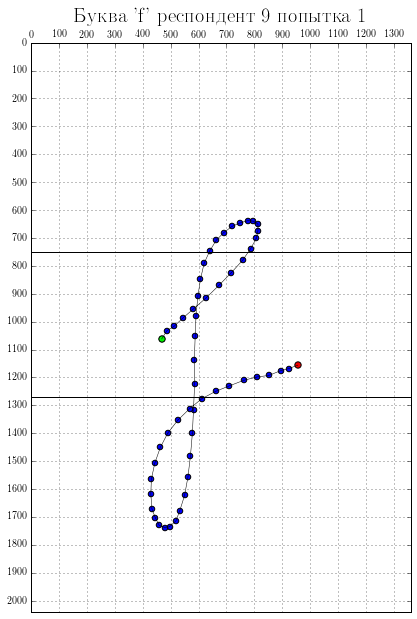

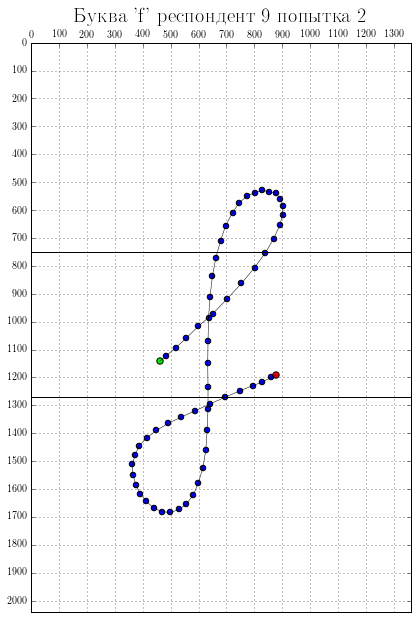

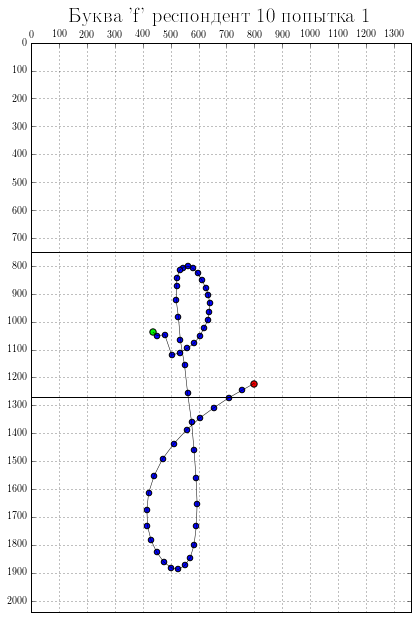

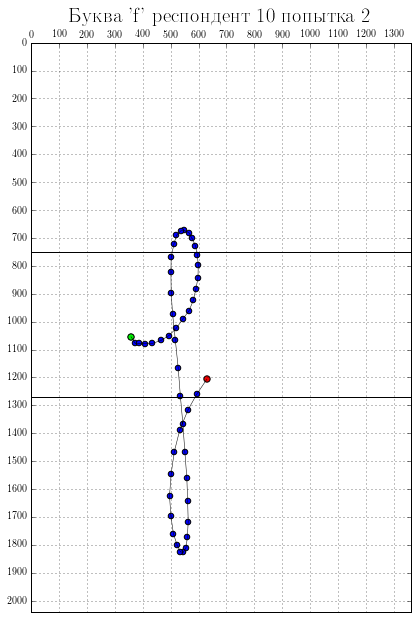

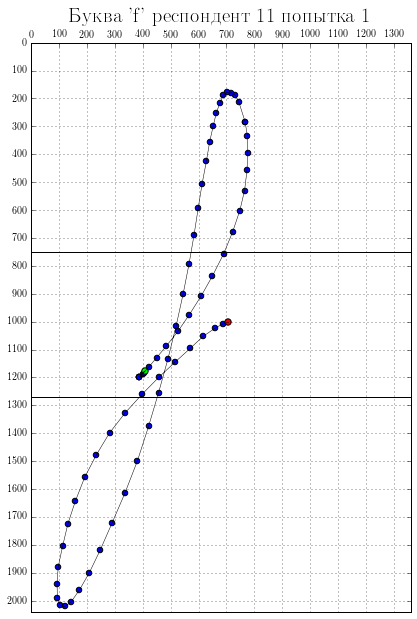

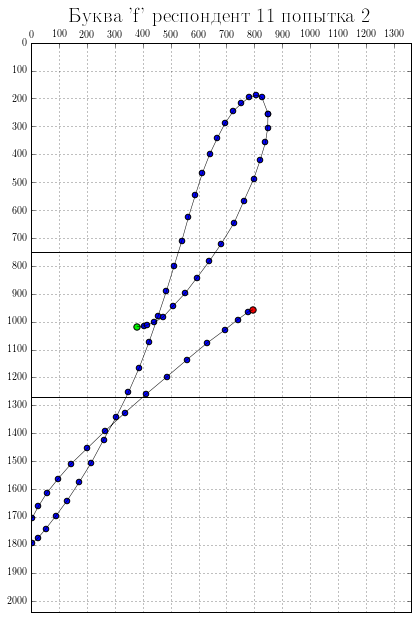

In [32]:
for writer in range(1, 11, 1):
    for repet in range(2):
        vis_letters((lexicon['f'], writer, repet), real_data)

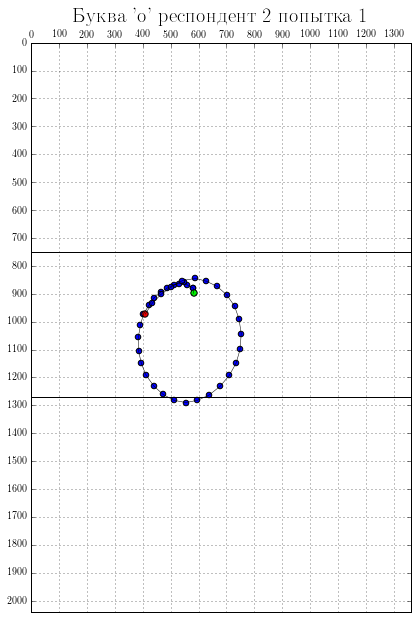

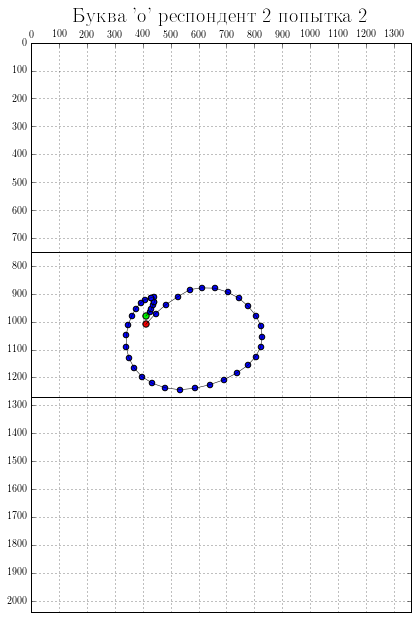

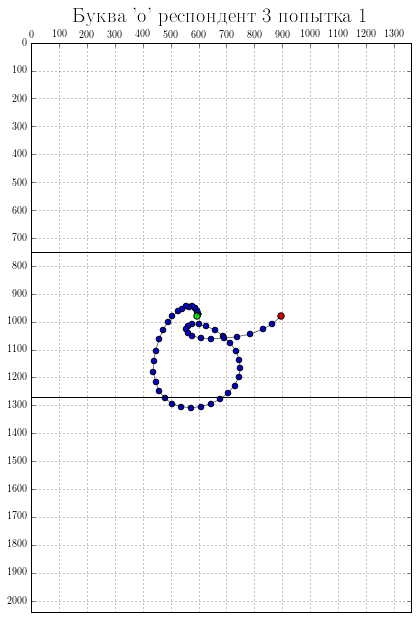

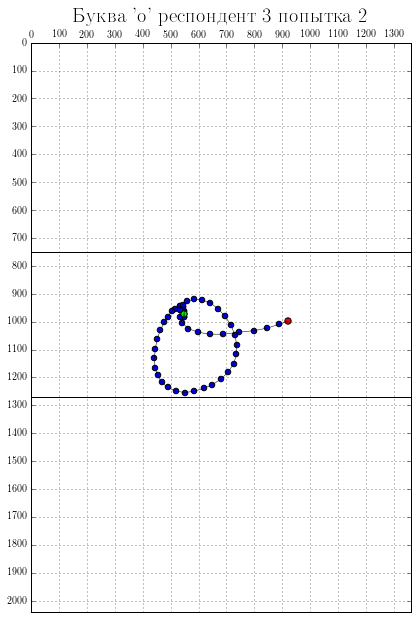

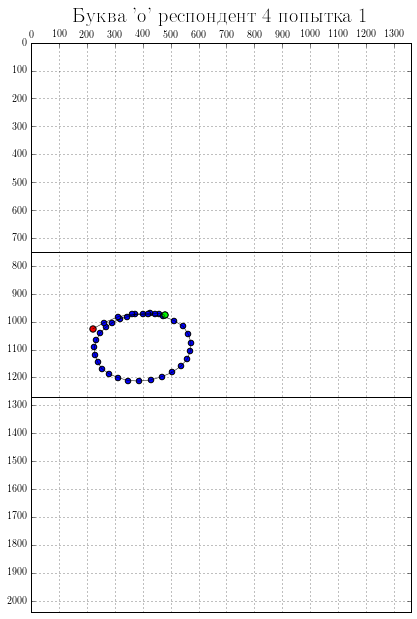

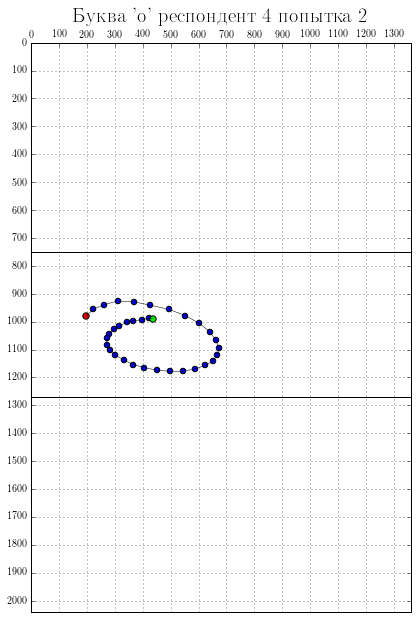

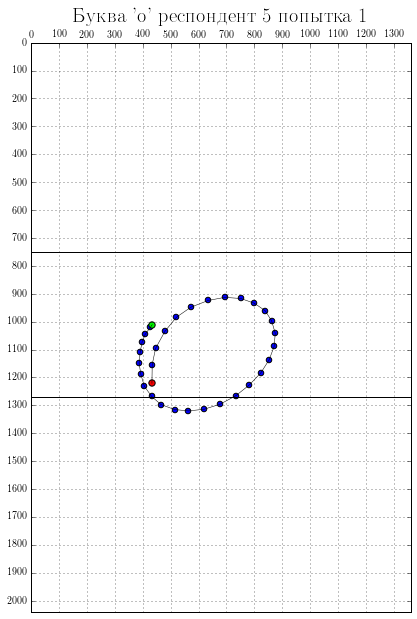

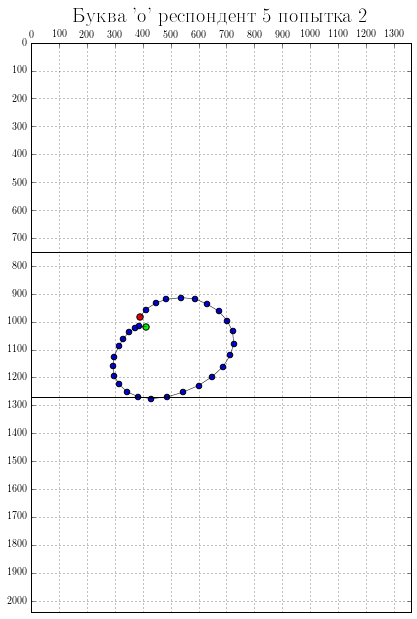

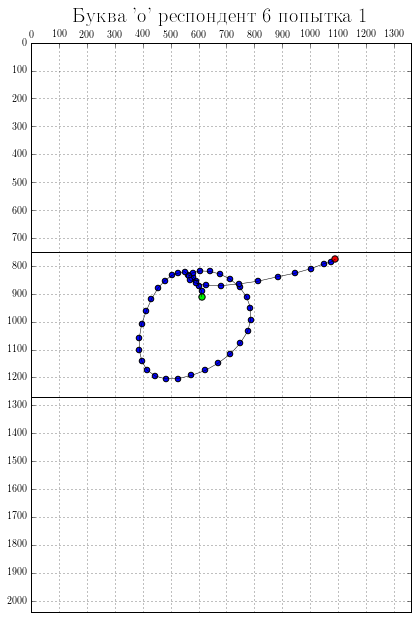

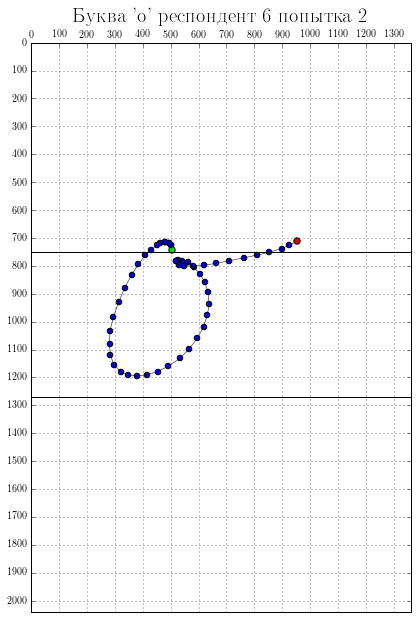

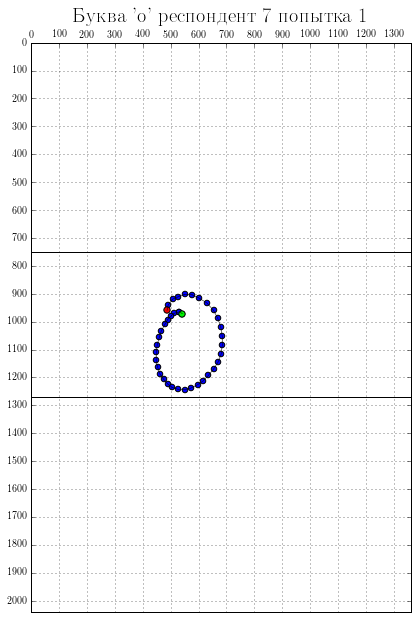

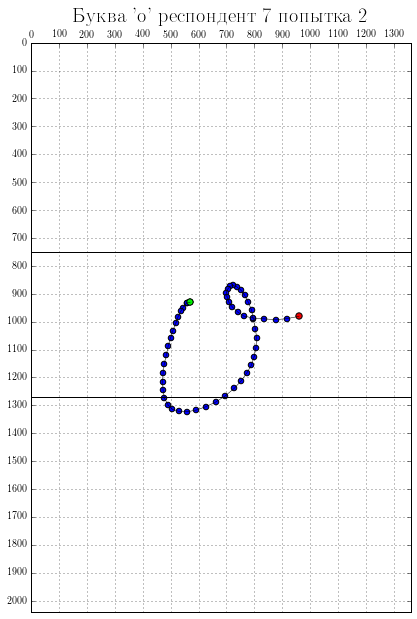

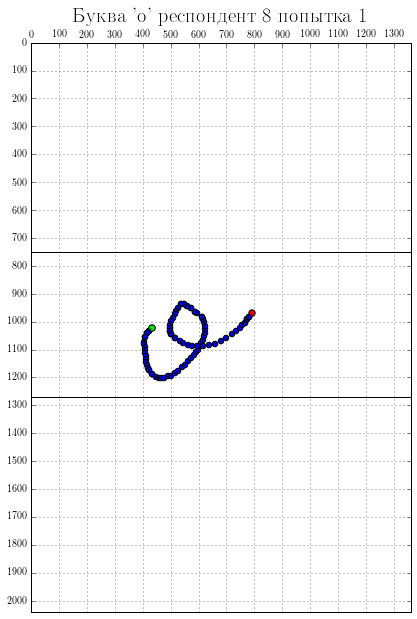

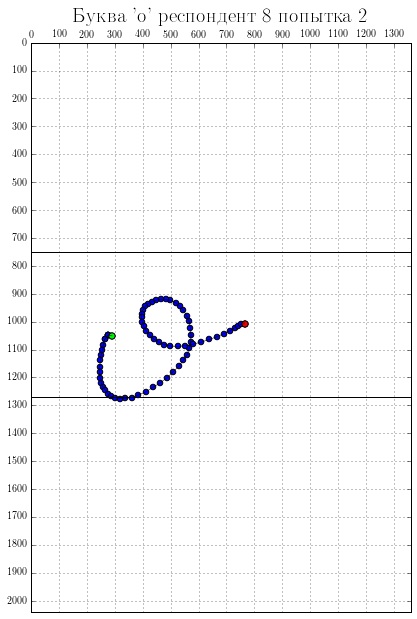

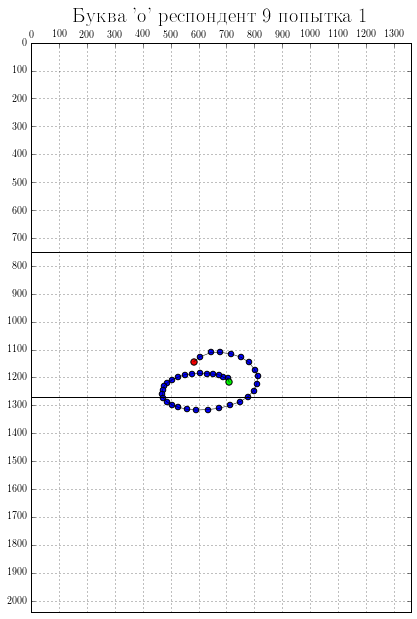

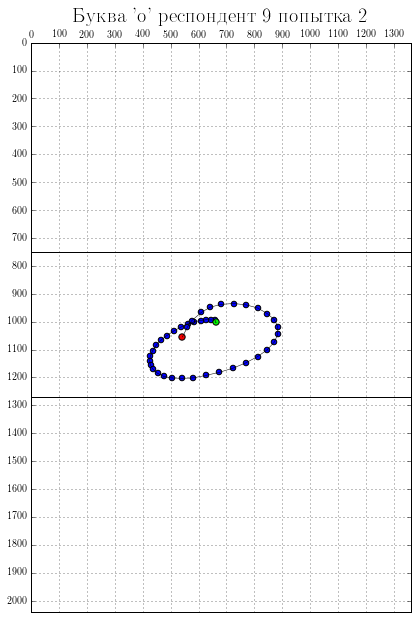

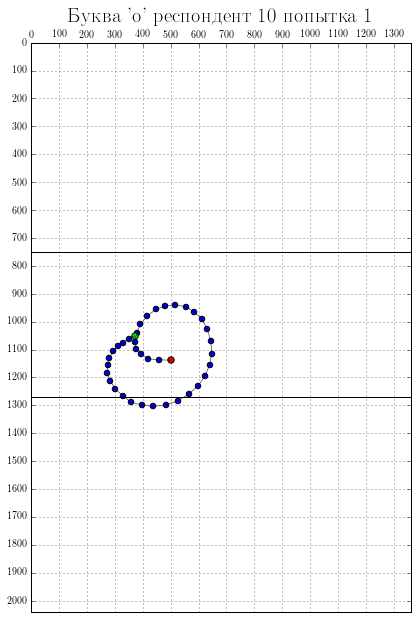

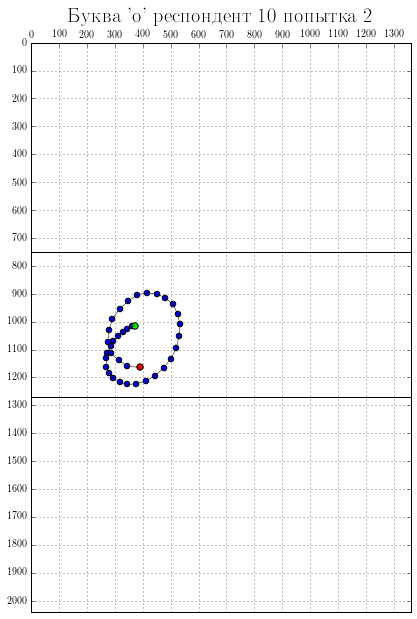

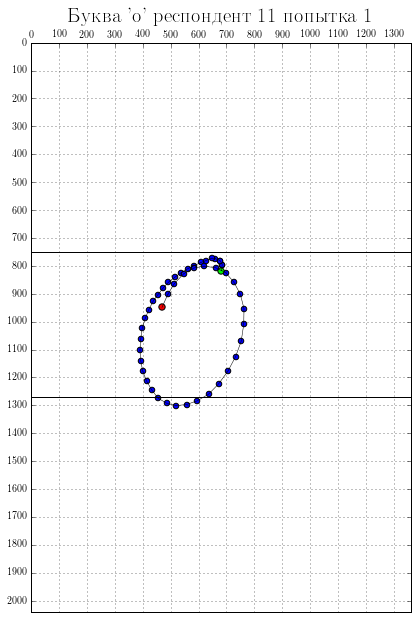

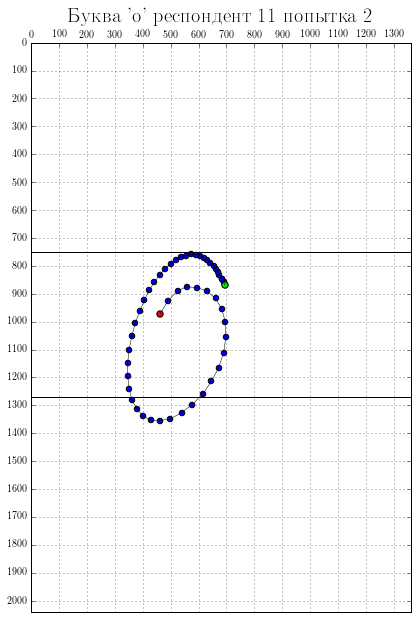

In [33]:
for writer in range(1, 11, 1):
    for repet in range(2):
        vis_letters((lexicon['o'], writer, repet), real_data)

## Making DTW preprocessing

In [14]:
def test(real_data, index_list):
    for ind in index_list:
        a = real_data[ind[0]].compressed().reshape(2, -1).T
        b = real_data[ind[1]].compressed().reshape(2, -1).T
        dist, D = sigproc.dtw(a, b, do_path=False)
        print("Буква '{0:s}'\tреспондент {1:d}\tпопытка 0 и 1: \t{2:.3f}".format(
                anti_lexicon[ind[0][0]], ind[0][1] + 1, dist))

In [15]:
index_list = [[(lexicon['y'], wr-1, 0), (lexicon['y'], wr-1, 1)] for wr in [2, 22,32]]
test(real_data, index_list)

Буква 'y'	респондент 2	попытка 0 и 1: 	8246.265
Буква 'y'	респондент 22	попытка 0 и 1: 	2660.133
Буква 'y'	респондент 32	попытка 0 и 1: 	3095.280


#### 2) Эксперименты, сравнение символов

In [16]:
def Letter_compare_predictions(real_data, letter_comparison, fines, alphas):
    """Train/Test eperiment: divided by repetitions"""
    global lexicon
    N_wr = 11
    models_pred = np.empty((letter_comparison.shape[0], alphas.size, 2*N_wr), dtype=np.str)
    compare_cnt = 0
    for l1, l2 in letter_comparison:
        #Training
        X_train = real_data[[lexicon[l1], lexicon[l2]], :N_wr, 0].reshape(-1, 2, max_d)
        y_train = np.ones((X_train.shape[0],1))
        y_train[X_train.shape[0]/2:] *= -1
        
        linear_models = [svm.smooth_qp_primal_real_solver(X_train, y_train, fines, gamma=1, alpha=alpha)
                             for alpha in alphas]
        #Testing
        X_test = real_data[[lexicon[l1], lexicon[l2]], :N_wr, 1].reshape(-1, 2, max_d)
        y_test = np.ones((X_test.shape[0],1))
        y_test[X_test.shape[0]//2:] *= -1
        for model_i in range(len(linear_models)):
            model = linear_models[model_i]
            pred = svm.predict(X_test, 'real', 'primal', model['a'], model['b'], X_train, y_train, fines)
            models_pred[compare_cnt, model_i, (pred==1).ravel()] = l1
            models_pred[compare_cnt, model_i, (pred==-1).ravel()] = l2
        compare_cnt += 1
    return models_pred

In [38]:
import time
tm = time.time()
Result = Letter_compare_predictions(real_data, np.array([['f', 'e'], ['i', 'j'],
                                                         ['a', 'd'], ['c', 'e'],
                                                         ['i', 'l'], ['u', 'y'],
                                                         ['j', 'y'], ['f', 'y'],
                                                         ['a', 'o'], ['g', 'y']]),
                                    fines=np.array([0, 0, 0]), alphas=np.linspace(1, 100, num=50))
tm = time.time() - tm
print(tm / 60, " min")

45.98864454825719  min


In [39]:
with change_printopt(threshold=10000):
    for i in range(Result.shape[0]):
        print(Result[i])

[['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']
 ['f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'e' 'e' 'e' 'e' 'f' 'e' 'e' 'e' 'e' 'e' 'e']

#### 3) Эксперименты на стандартным таском (не готовы)

In [1]:
def Standard_task(real_data, y_multiarr, fines, alphas, gamma=1):
    """Train/Test eperiment: divided by repetitions"""
    global y_values, lexicon, max_d
    import time
    tm = time.time()
    n_tm = time.time()
    N_wr = real_data.shape[1]
    N_obj = real_data[:, :-1, :].size / (2*max_d)
    print("---|||--- Standard_task ---|||---",flush=True)
    print(flush=True)
    models_pred = np.empty((N_wr, N_obj, alphas.size), dtype=np.str)
    for wr in range(N_wr):
        #Training
        #########################
        print("Start with writer", wr+1, ": ",(time.time() - tm) / 60, " min from start", flush=True)
        #########################
        train_wrs = np.array(list(set(np.arange(N_wr)) - set([wr])))
        X_train = real_data[:, train_wrs, :].reshape(-1, 2, max_d)
        y_train = y_multiarr[:, train_wrs, :].reshape(-1, 1)
        
        linear_models = [svm.multi_solver(X_train,  y_train, 'real', 'primal', fines=fines, gamma=1, alpha=alpha)
                              for alpha in alphas]
        #########################
        n_tm = time.time() - n_tm
        print("\t",n_tm / 60, " min for training", flush=True)
        print("\t",(time.time() - tm) / 60, " min from start", flush=True)
        #########################
        print("\tWriter ", wr+1, flush=True)
        print("\tTraining done!", flush=True)
        print(flush=True)
        #Testing
        X_test = real_data[:, wr, :].reshape(-1, 2, max_d)
        y_test = y_multiarr[:, wr, :].reshape(-1, 1)
        for i, model in enumerate(linear_models):
            models_pred[wr, :, i] = svm.multi_predict(X_test, 'real', 'primal',
                                      a_list=model, X_train=X_train, y_train=y_train, fines=fines)
        #########################
        n_tm = time.time() - n_tm
        print("\t",n_tm / 60, " min for prediction", flush=True)
        print("\t",(time.time() - tm) / 60, " min from start", flush=True)
        #########################
        print("\tWriter ", wr+1, flush=True)
        print("\tTesting done!", flush=True)
        print(flush=True)
    print(flush=True)
    print("---|||--- Time elapsed: ", (time.time() - tm)/60, " min ---|||---")
    
    return models_pred

In [33]:
N_wr = 11
wr=0
fines=np.array([0, 0, 0])
alpha = 1
y = values

train_wrs = np.array(list(set(np.arange(N_wr)) - set([wr])))
X_train = real_data[:, train_wrs, :].reshape(-1, 2, max_d)
y_train = np.tile(y_values,(1, 11, 1)).T[:, train_wrs, :].reshape(-1, 1)
y_cl = np.unique(y_train)[0]
y_bin = -1*np.ones(y_train.shape)
y_bin[y == y_cl] = 1

In [ ]:
%%prun  -T standard_task_mini_logger.txt 
Result_standard = Standard_task(real_data[:,:11,[0]], np.tile(y_values,(1, 11, 1)).T,
                                np.array([0, 0, 0]), np.array([1]))

---|||--- Standard_task ---|||---

Start with writer 1 :  7.258256276448568e-05  min from start


In [34]:
%prun  -T svm_smooth_real_logger.txt svm.smooth_qp_primal_real_solver(X_train[::4], y_bin[::4], fines=fines, gamma=1, alpha=alpha, verbose=True)

Time elapsed [DTW]:  767.846786737442
Time elapsed [Cone QP preparation]:  0.05605125427246094
     pcost       dcost       gap    pres   dres
 0: -3.0995e+00  3.1123e+01  1e+03  2e+00  5e+07
 1:  2.5236e+01 -8.9914e+00  4e+01  3e-02  8e+05
 2:  1.9068e+00 -3.1153e-01  3e+00  2e-03  4e+04
 3:  1.9533e-01 -2.9412e-02  3e-01  2e-04  4e+03
 4:  6.5325e-02 -1.0166e-02  9e-02  5e-05  1e+03
 5:  2.2360e-02 -3.7311e-03  3e-02  2e-05  4e+02
 6:  1.2384e-02 -2.4147e-03  2e-02  8e-06  2e+02
 7:  8.3298e-03 -1.7964e-03  1e-02  5e-06  1e+02
 8:  4.8769e-03 -1.2446e-03  7e-03  3e-06  8e+01
 9:  2.1700e-03 -7.3466e-04  3e-03  1e-06  3e+01
10:  5.2584e-04 -2.3311e-04  8e-04  2e-07  6e+00
11:  2.2079e-05 -1.0499e-05  3e-05  1e-08  3e-01
12:  6.3133e-06 -2.8401e-06  9e-06  2e-09  6e-02
13:  4.6862e-06 -2.1600e-06  7e-06  1e-09  4e-02
14:  3.9431e-06 -1.9251e-06  6e-06  1e-09  3e-02
15:  2.4448e-06 -1.1144e-06  4e-06  6e-10  2e-02
16:  9.9492e-07 -3.7056e-07  1e-06  9e-12  3e-04
17:  2.6216e-07 -9.2898e

In [35]:
max_time = 0
cnt = 0
for wr in range(11):
    for symb in range(values.size):
        for rep in range(2):
            cnt +=1
            a = real_data[symb, wr, 0].compressed().reshape(2, -1).T
            b = real_data[symb, wr, 0].compressed().reshape(2, -1).T
            tm = time.time() 
            sigproc.dtw(a, b)
            tm = time.time() - tm
            if max_time < tm:
                max_time = tm                
print(max_time / 60, cnt)

0.0016565362612406412 1364
